In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import mpl_scatter_density

In [2]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(12,10))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

In [3]:
array = pd.read_table('biomarkers_mrp_rv_ma_array_gbe.tsv.gz')
exome = pd.read_table('biomarkers_mrp_rv_ma_exome_gbe.tsv.gz')
array = array[['GBE_short_name', 'gene', 'num_variants_pav', 'log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav']]
array.columns = ['GBE_short_name', 'gene', 'num_variants_pav_array', 'log_10_BF_array']
exome = exome[['GBE_short_name', 'gene', 'num_variants_pav', 'log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav']]
exome.columns = ['GBE_short_name', 'gene', 'num_variants_pav_exome', 'log_10_BF_exome']
merged = array.merge(exome)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


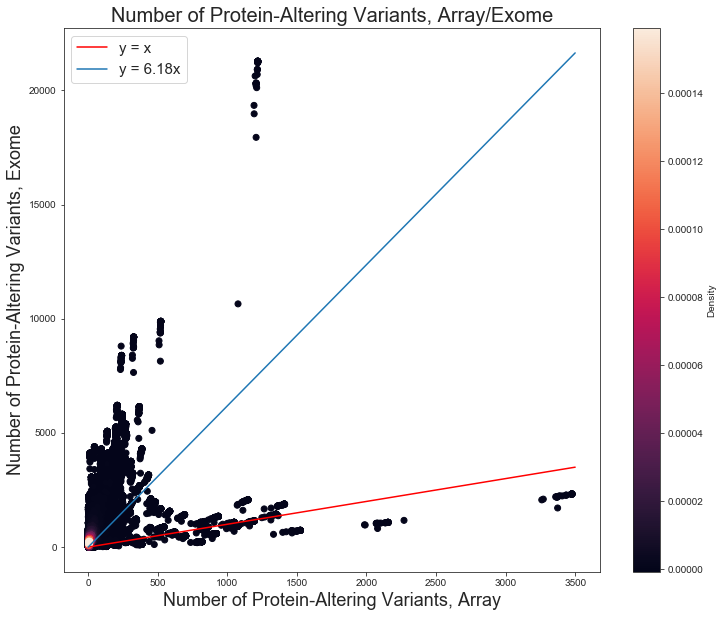

In [5]:
sns.set_style('white')
sns.set_style('ticks')
density_scatter(np.array([float(x) for x in merged['num_variants_pav_array']]), np.array([float(x) for x in merged['num_variants_pav_exome']]), bins=[1000,1000])
#plt.xlim([0,18000])
#plt.ylim([0,18000])
plt.xlabel('Number of Protein-Altering Variants, Array',fontsize=18)
plt.ylabel('Number of Protein-Altering Variants, Exome',fontsize=18)
plt.title('Number of Protein-Altering Variants, Array/Exome',fontsize=20)

x = np.linspace(0,3500,3501)
plt.plot(x,x, color='red',label='y = x')
m, _, _, _ = np.linalg.lstsq(merged['num_variants_pav_array'][:,np.newaxis], merged['num_variants_pav_exome'][:,np.newaxis])
plt.plot(x, m[0][0]*x, label='y = ' + str(m[0][0])[:4] + 'x')
plt.legend(fontsize=15)
#plt.grid()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/opt/anaconda3/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


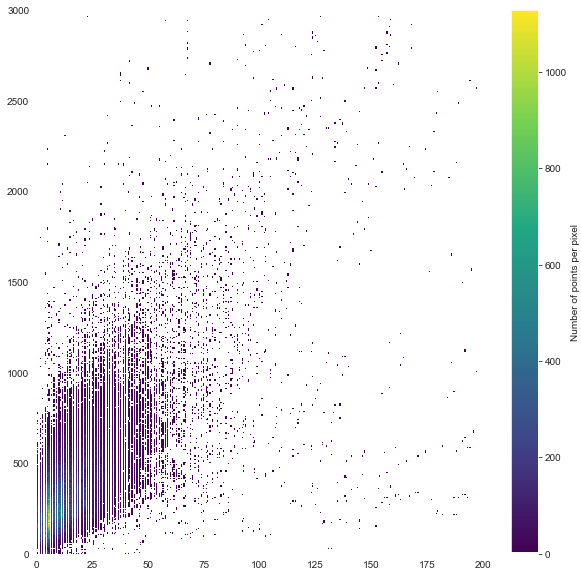

In [15]:
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    plt.xlim([0,200])
    plt.ylim([0,3000])
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure(figsize=(10,10))
using_mpl_scatter_density(fig, np.array([float(x) for x in merged['num_variants_pav_array']]), np.array([float(x) for x in merged['num_variants_pav_exome']]))
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


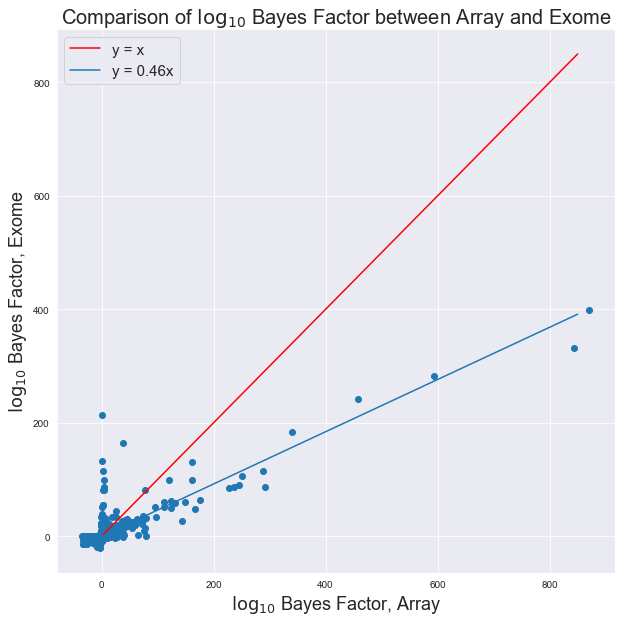

In [16]:
sns.set_style('dark')
plt.figure(figsize=(10,10))
plt.scatter(merged['log_10_BF_array'], merged['log_10_BF_exome'])
plt.xlabel('$\log_{10}$ Bayes Factor, Array',fontsize=18)
plt.ylabel('$\log_{10}$ Bayes Factor, Exome',fontsize=18)
plt.title('Comparison of $\log_{10}$ Bayes Factor between Array and Exome',fontsize=20)

x = np.linspace(0,850,850)
plt.plot(x,x, color='red',label='y = x')
m, _, _, _ = np.linalg.lstsq(merged['log_10_BF_array'][:,np.newaxis], merged['log_10_BF_exome'][:,np.newaxis])

plt.plot(x, m[0][0]*x, label='y = ' + str(m[0][0])[:4] + 'x')
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [17]:
merged['diff'] = merged['log_10_BF_exome'] - merged['log_10_BF_array']
merged.sort_values('diff', ascending=False)[:20].to_csv('exome_array_diff.tsv', sep='\t', index=False)

In [18]:
var = pd.read_table('biomarkers_mrp_rv_exome_var_gbe.tsv.gz')[['GBE_short_name', 'gene','num_variants_pav','log_10_BF_study_similar_var_independent_sigma_m_var_pav']]
mpc_pli = pd.read_table('biomarkers_mrp_rv_exome_gbe.tsv.gz')[['GBE_short_name', 'gene','num_variants_mpc_pav','num_variants_pli_pav','log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav']]
var.columns = ['GBE_short_name', 'gene', 'num_variants_pav', 'log10bf_var']
mpc_pli.columns = ['GBE_short_name', 'gene', 'num_variants_mpc_pav','num_variants_pli_pav', 'log10bf_mpc_pli']
merged_var = var.merge(mpc_pli)

In [19]:
merged_var['diff'] = merged_var['log10bf_mpc_pli'] - merged_var['log10bf_var']
merged_var.sort_values('diff',ascending=False)[:10].to_csv('mpc_pli_diff.tsv', index=False, sep='\t')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


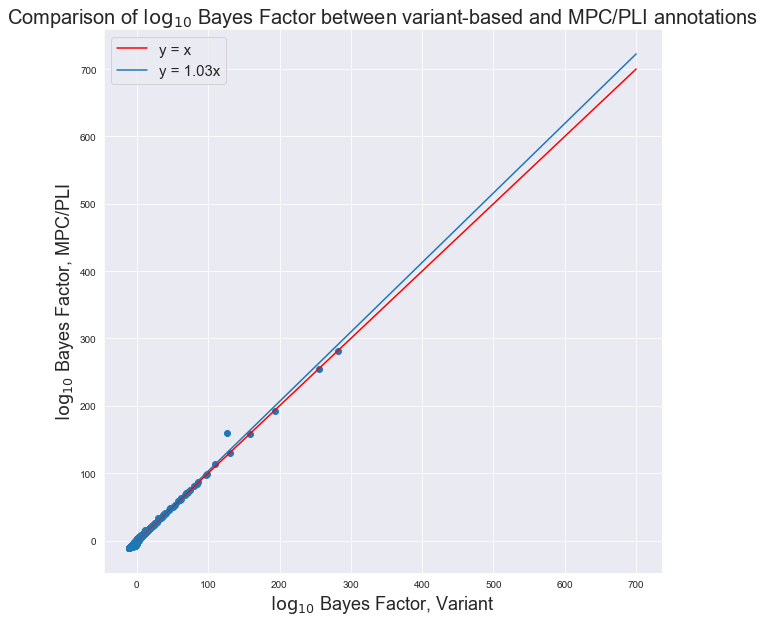

In [20]:
sns.set_style('dark')
plt.figure(figsize=(10,10))
plt.scatter(merged_var['log10bf_var'], merged_var['log10bf_mpc_pli'])
plt.xlabel('$\log_{10}$ Bayes Factor, Variant',fontsize=18)
plt.ylabel('$\log_{10}$ Bayes Factor, MPC/PLI',fontsize=18)
plt.title('Comparison of $\log_{10}$ Bayes Factor between variant-based and MPC/PLI annotations',fontsize=20)

x = np.linspace(0,700,700)
plt.plot(x,x, color='red',label='y = x')
m, _, _, _ = np.linalg.lstsq(merged_var['log10bf_var'][:,np.newaxis], merged_var['log10bf_mpc_pli'][:,np.newaxis])

plt.plot(x, m[0][0]*x, label='y = ' + str(m[0][0])[:4] + 'x')
plt.legend(fontsize=15)
plt.grid()
plt.show()